## Advanced Lane Detection Pipeline

In [1]:
import numpy as np
import cv2
import glob
from utils import cameraCaliberation
from utils.threshold import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

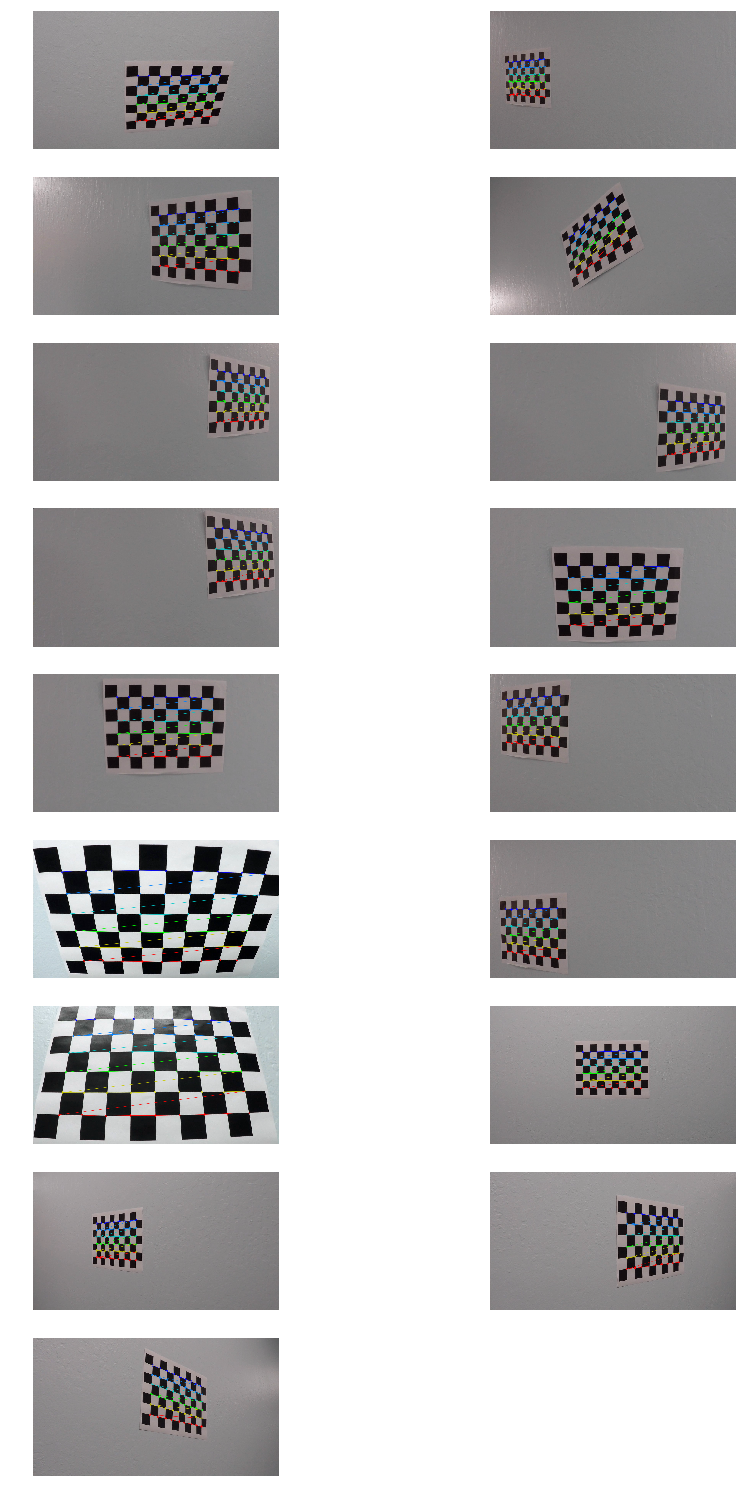

In [2]:
## Camera Caliberation
cal_path = 'camera_cal/calibration*.jpg'
(ret, mtx, dist, rvecs, tvecs), fig = cameraCaliberation.calc_caliberation_matrix(cal_path)

fig.set_size_inches(15,30)

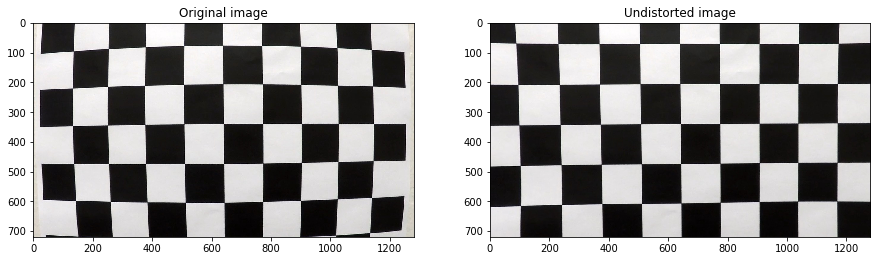

In [3]:
##TEST Undistort images

test_img = plt.imread("camera_cal/calibration1.jpg")
undist_img = cameraCaliberation.img_undistort(test_img, mtx, dist)

plt.figure(figsize=(15,30))
plt.subplot(1,2,1)
plt.imshow(test_img)
plt.title('Original image')

plt.subplot(1,2,2)
plt.imshow(undist_img)
plt.title('Undistorted image')


## Lane finding Pipeline

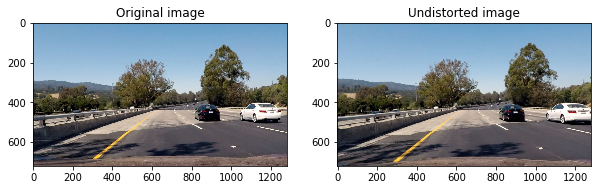

In [4]:
## 1. Testing distortion for first frame of video:

test_img = plt.imread("test_images/test4.jpg")
undist_img = cameraCaliberation.img_undistort(test_img, mtx, dist)

plt.figure(figsize=(10,30))
plt.subplot(1,2,1)
plt.imshow(test_img)
plt.title('Original image')

plt.subplot(1,2,2)
plt.imshow(undist_img)
plt.title('Undistorted image')

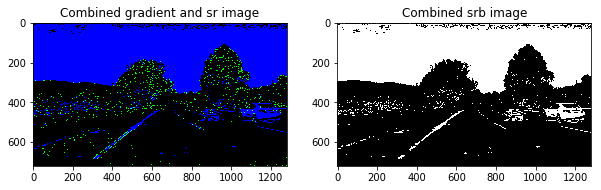

In [5]:
## 2. Thresholding for first frame of video

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
color_thresh = combine_thresh(test_img, color = True)
plt.imshow(color_thresh)
plt.title('Combined gradient and sr image')

plt.subplot(1,2,2)
srb_thresh = combine_thresh(test_img)
plt.imshow(srb_thresh, cmap='gray')
plt.title('Combined srb image')

In [6]:
# def img_warped(img):
#     img_size = [1280,720]
#     l_offset, r_offset = 300, 1000

#     # Define 4 source points src = np.float32([[,],[,],[,],[,]])
#     # Define 4 destination points dst = np.float32([[,],[,],[,],[,]])
#     src_points = np.float32([[254,688],[599,451],[684,451],[1056,688]])
#     #dst = np.float32([[250,720],[250,0],[1000,0],[1000,720])
#     dst_points = np.float32([[l_offset,img_size[1]],[l_offset,0],[r_offset,0],[r_offset,img_size[1]]])
#     # Get the transform matrix, M
#     M = cv2.getPerspectiveTransform(src_points, dst_points)
#     M_inv = cv2.getPerspectiveTransform(dst_points, src_points)
#     # Warp the image to top-down view
#     warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
#     # Return the resulting image and matrix
#     return warped, M, M_inv

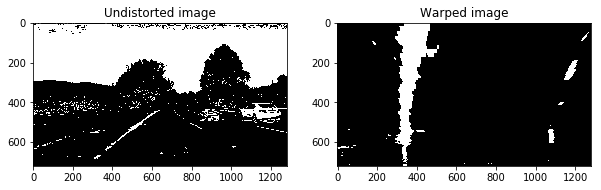

In [8]:
## 3. Perspective Transform and warping for first frame of video

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
plt.imshow(srb_thresh,  cmap='gray')
plt.title('Undistorted image')

plt.subplot(1,2,2)
binary_warped, M, M_inv = cameraCaliberation.img_warped(srb_thresh)

plt.imshow(binary_warped,  cmap='gray')
plt.title('Warped image')

In [ ]:
## 4. Detect Lane Lines 
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[(binary_warped.shape[0]//2):,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Finding peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
# Base indices for left and right lane lines
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 9

# Height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identifing the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Margin in which to search
margin = 100
# Minimum number of pixels found to recenter window
minpix = 50

# Empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Steping through windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    #print("Window dimensions: ", win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high )
    # Drawing the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 
    
    # Identifying the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    #print("Indices:", good_left_inds, good_right_inds )
    # Appending these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # Recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenating the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extracting left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
# left_fit/right_fit are polynomial coefficients
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

## Visualization
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
## the fitted line 
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped')

plt.subplot(1,2,2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Lane Detected')

In [ ]:
## 5. Detect Lane Curvature
# Define conversions in x and y from pixels space to meters
ym_per_pix = 4.0/72.0 # meters per pixel in y dimension
xm_per_pix = 3.7/688.0 # meters per pixel in x dimension

y_eval = np.max(ploty)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

In [9]:
## 4. Detect Lane Lines

class Line():
    def __init__(self):
        
        #Frame count
        self.frame_count = 0
        #If the first frame or if needed in next frame
        self.use_hist = True
        #Polynomial coefficients for the line fit
        self.fit_coeff = None
        #The last best fit for the line polynomial
        self.lastfit_coeff = None
        
        self.left_fit = [np.array([False])] 
        self.right_fit = [np.array([False])] 
        
        self.y_eval = 700
        self.midx = 640
        self.ym_per_pix = 4.1/72.0 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/688.0 # meters per pixel in x dimension
        self.curvature = 0
    
    def update_fits(self, left_fit, right_fit):
        self.left_fit = left_fit
        self.right_fit = right_fit

    def get_dist_from_center(self):
        x_left_pix = self.left_fit[0]*(self.y_eval**2) + self.left_fit[1]*self.y_eval + self.left_fit[2]
        x_right_pix = self.right_fit[0]*(self.y_eval**2) + self.right_fit[1]*self.y_eval + self.right_fit[2]
        
        return ((x_left_pix + x_right_pix)/2.0 - self.midx) * self.xm_per_pix
        
    


In [10]:
def pipeline(img):
    
    #1. Undistort Image
    undist_img = cameraCaliberation.img_undistort(np.copy(img), mtx, dist)
    #2. Threshold and Perspective Transform
    srb_thresh = combine_thresh(undist_img)
    binary_warped, M_mat, M_inv_mat = cameraCaliberation.img_warped(srb_thresh)
  
    # Number of sliding windows
    nwindows = 9
    # Margin in which to search
    margin = 100
    # Minimum number of pixels found to recenter window
    minpix = 50
    # Height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    if lane.use_hist == True:

        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[(binary_warped.shape[0]//2):,:], axis=0)

        # Finding peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        # Base indices for left and right lane lines
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # Identifing the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Steping through windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Identifying the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            #print("Indices:", good_left_inds, good_right_inds )
            # Appending these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # Recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenating the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extracting left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        # left_fit/right_fit are polynomial coefficients
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        lane.update_fits(left_fit, right_fit)
        lane.use_hist = False
        
    else:
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        left_fit = lane.left_fit
        right_fit = lane.right_fit
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        
        # Again extracting left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        # Fit a second order polynomial to each
        lane.update_fits(np.polyfit(lefty, leftx, 2), np.polyfit(righty, rightx, 2))
        left_fit = lane.left_fit
        right_fit = lane.right_fit
        
        # Recenter next window on their mean position
        if len(left_lane_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[left_lane_inds]))
        if len(right_lane_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[right_lane_inds]))
        
    ## Visualization
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    ## the fitted line 
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
     # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*lane.ym_per_pix, right_fitx*lane.xm_per_pix, 2)
    # Calculate the new radii of curvature
    radius_of_curvature = ((1 + (2*fit_cr[0]*lane.y_eval*lane.ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

#     plt.figure(figsize=(10,40))
#     plt.subplot(1,2,1)
#     plt.imshow(binary_warped, cmap='gray')
#     plt.title('Binary Warped')

#     plt.subplot(1,2,2)
#     plt.imshow(result)
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

    ## Add Radius of Curvature values
    cv2.putText(result,'Radius of Curvature: %.2fm' % radius_of_curvature ,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    ## Add distance from center values
    dist_from_center = lane.get_dist_from_center()
    if dist_from_center < 0:
        text = 'left'
    else:
        text = 'right'
    cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(dist_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    return result

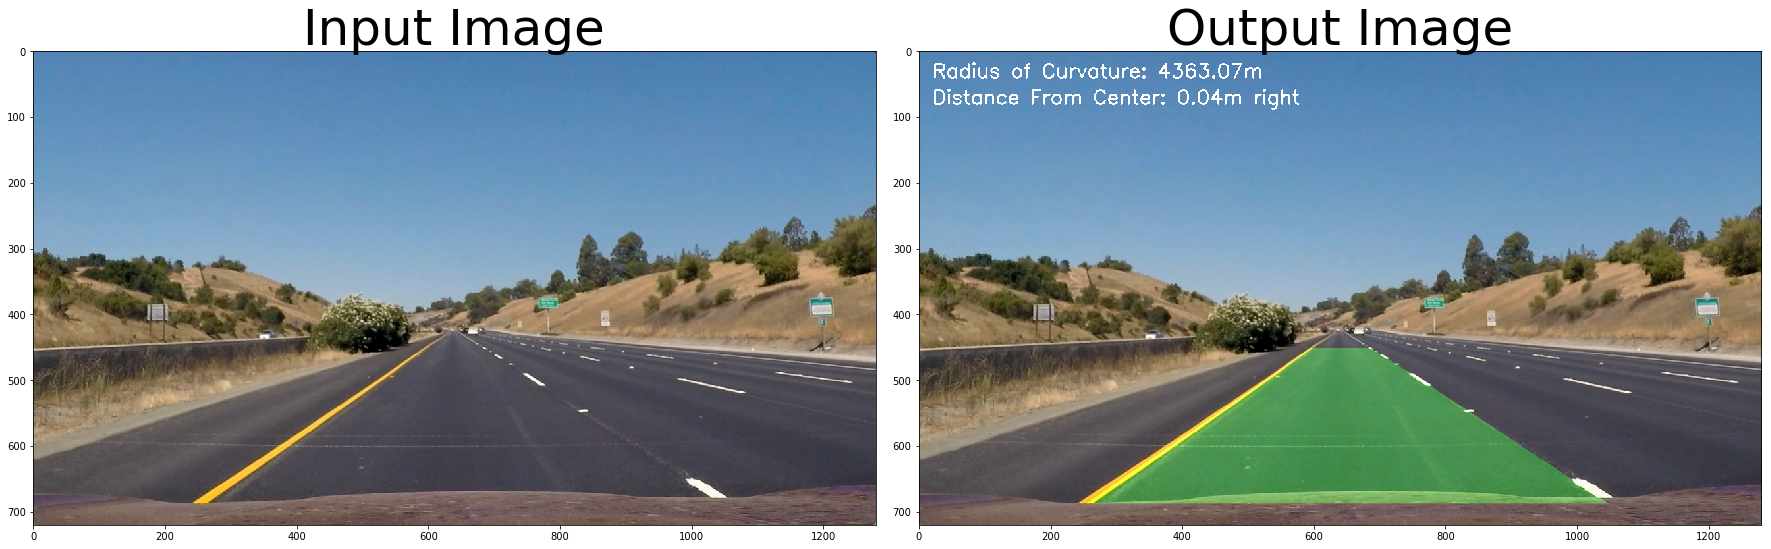

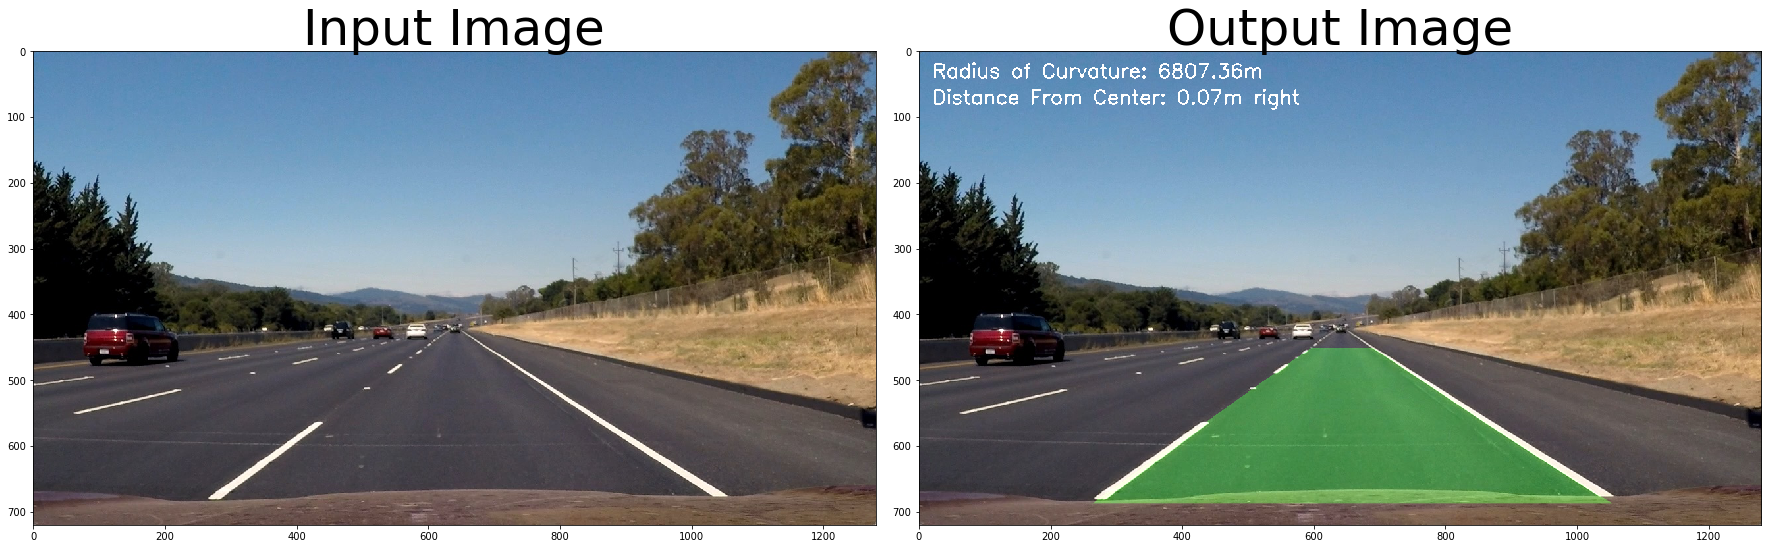

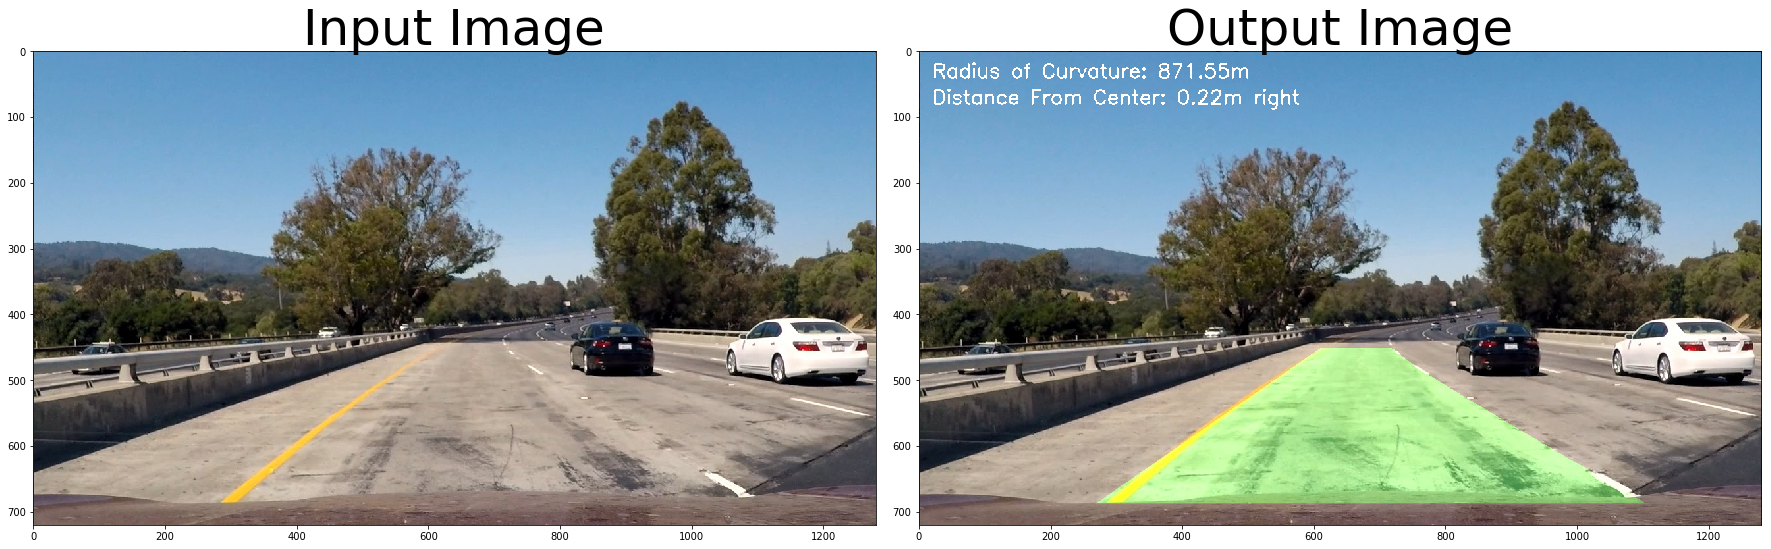

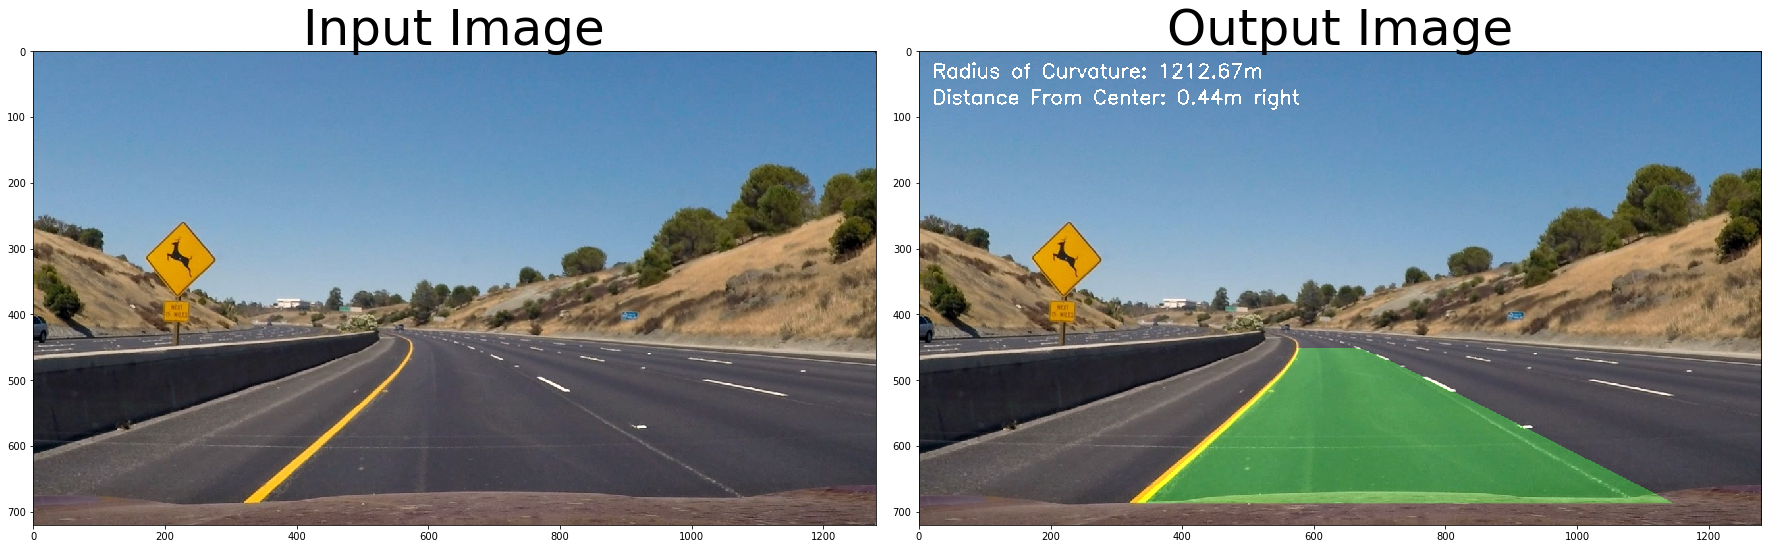

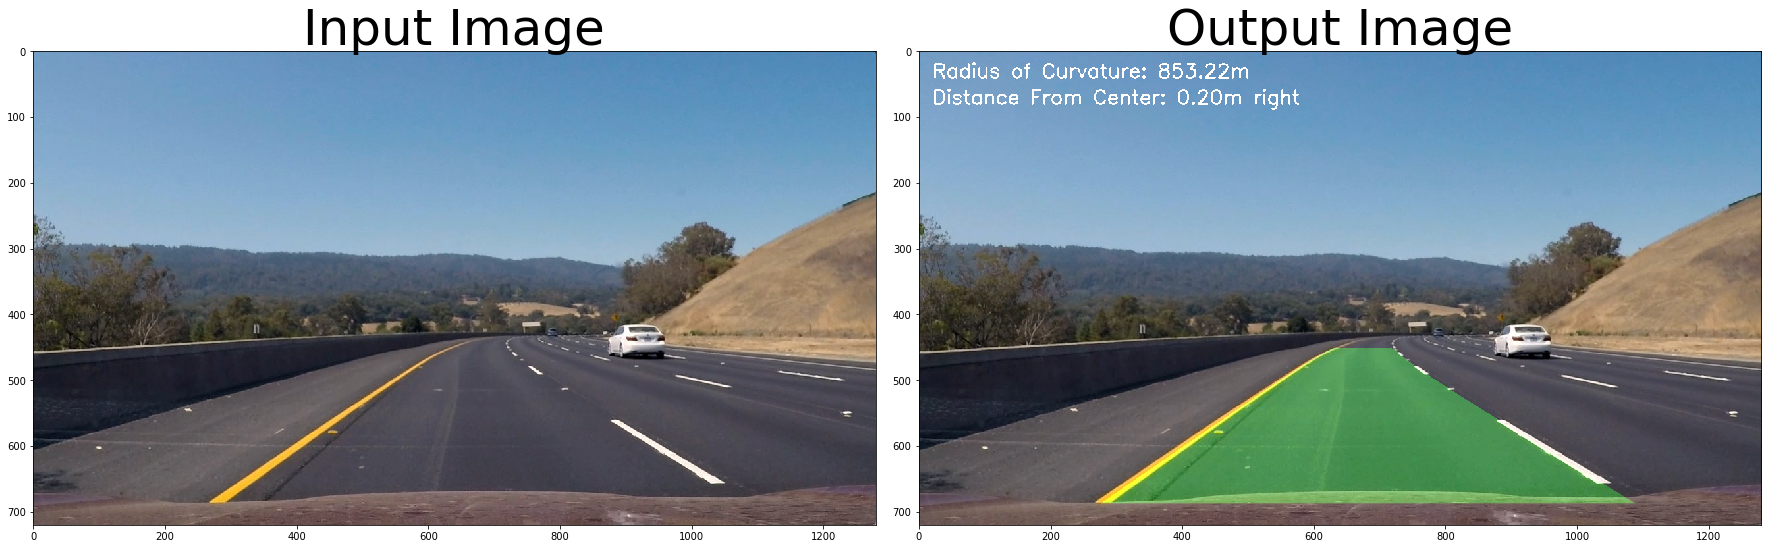

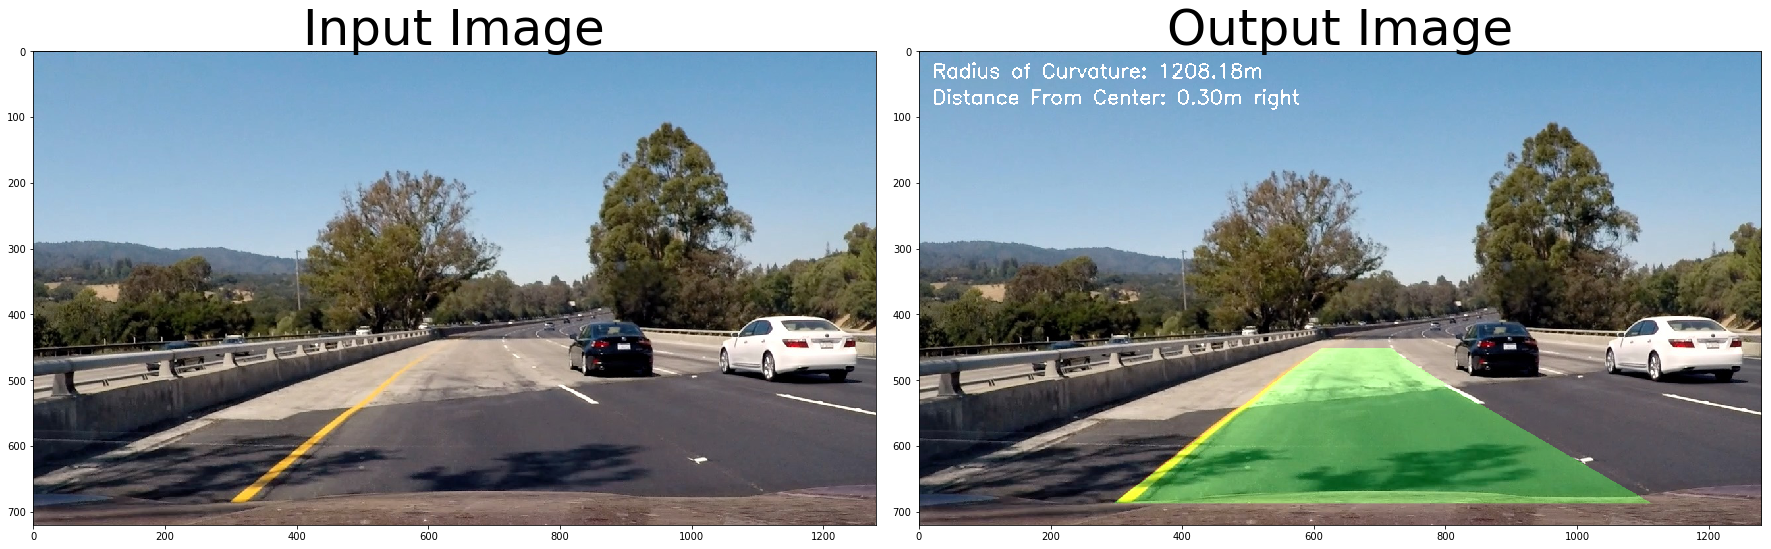

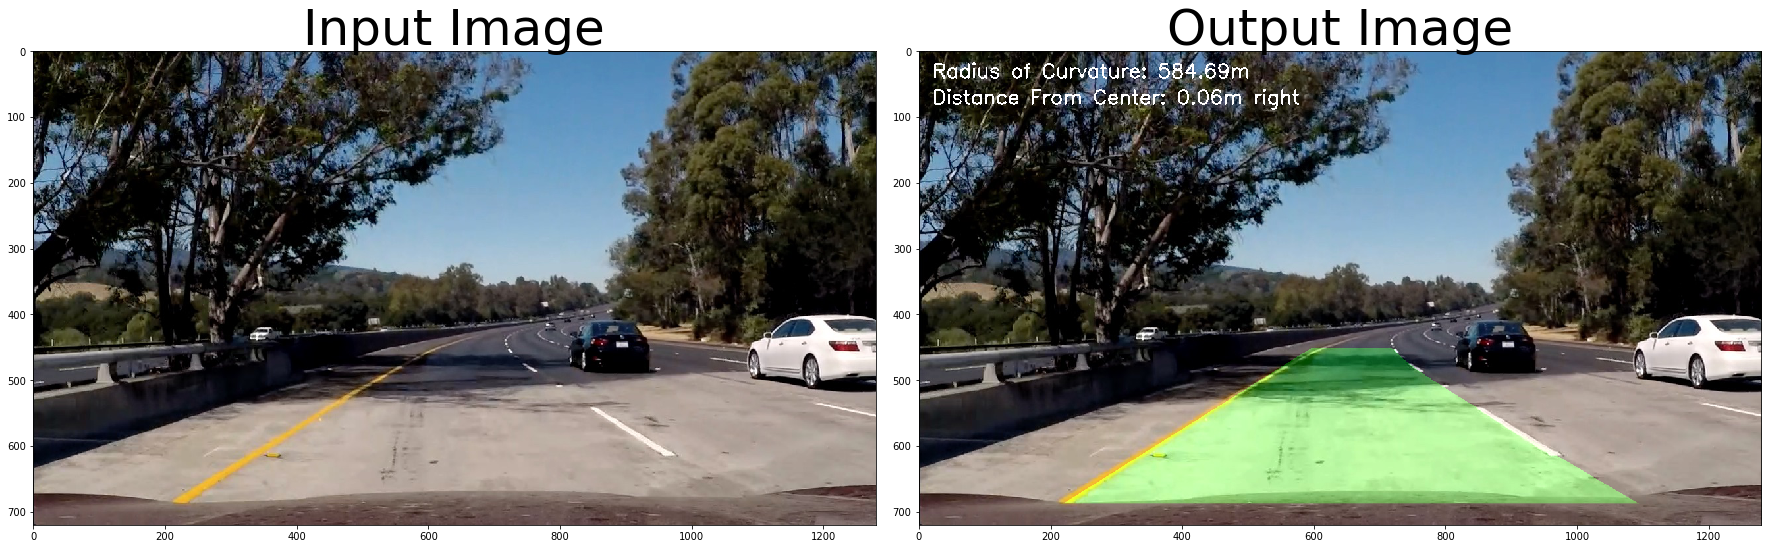

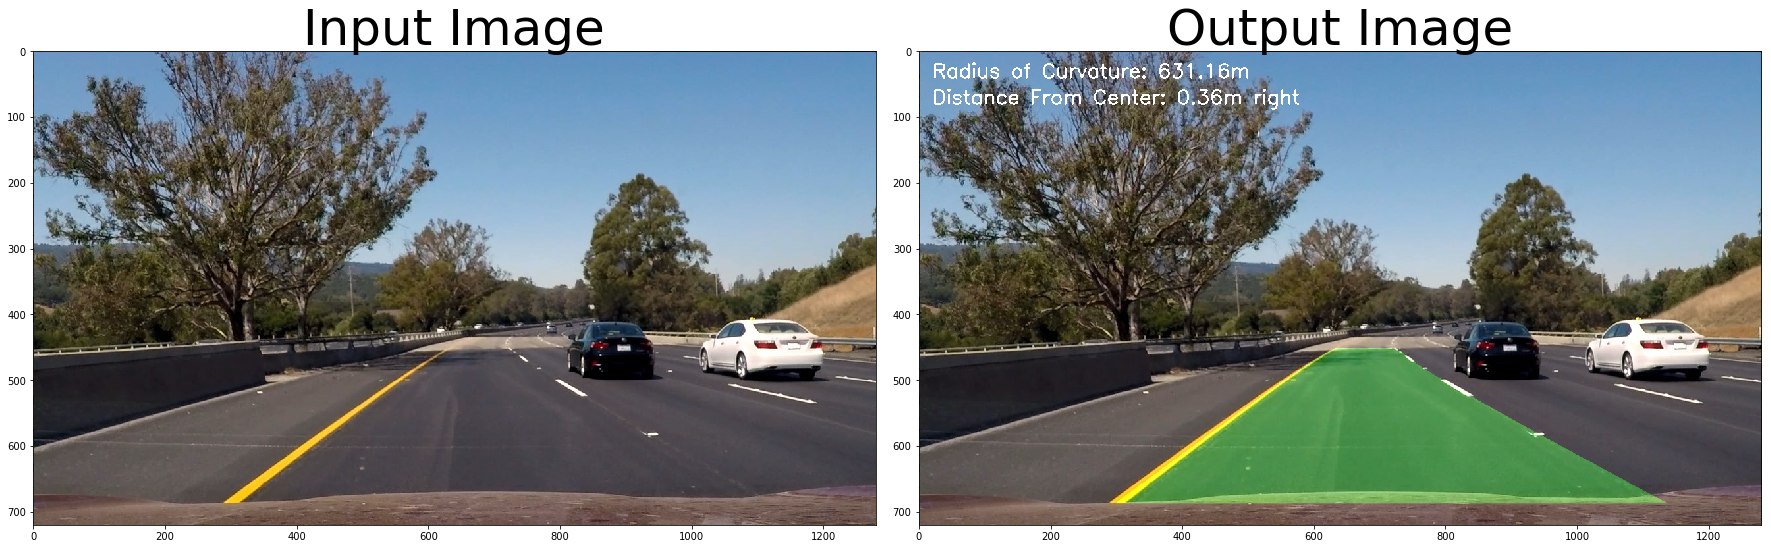

In [11]:
image_filenames = glob.glob('test_images/'+'*.jpg')
for fname in image_filenames:
    lane = Line()
    img = mpimg.imread(fname)
    output = pipeline(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Input Image', fontsize=50)
    ax2.imshow(output)
    ax2.set_title('Output Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.savefig('output_images/'+(fname.split('/')[-1]).split('.')[0]+'_output.png', format='png')

In [12]:
# from utils.pipeline import Pipeline
# from utils.line import Line
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lane = Line()

lane_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(lane_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(lane_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:19<00:00,  4.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 19s, sys: 1min 1s, total: 5min 21s
Wall time: 4min 20s
